Данный ноутбук содержит сравнение моделей обученных на разных данных, а именно на исходном датасете (NIH Chest X-rays) и на правильно размеченных данных (NODE21 и XRay Chest Nodule). Для оценки эффективности моделей использовались одинаковые тестовые наборы данных.

Прежде чем запускать данный ноутбук, Вам необходимо:
1) Сохранить id пациентов из выборок и тестовый набор данных в NODE21+XRay-Chest-Nodule.ipynb.
2) Обучить модель классификации Nodule/Mass на верноразмеченных данных в NODE21+XRay-Chest-Nodule.ipynb.

# Библиотеки

In [1]:
import pandas as pd
import numpy as np 
import keras_cv
import tensorflow as tf
import os
from glob import glob
import matplotlib.pyplot as plt
from itertools import chain
from keras.applications.densenet import DenseNet121
from keras import Model
from keras import layers
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from tensorflow.keras import backend as keras
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam 
from sklearn.utils import class_weight
%matplotlib inline
os.environ["KERAS_BACKEND"] = "tensorflow"

2024-08-27 20:36:04.684010: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-27 20:36:05.398913: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Параметры

In [2]:
DATA_FOLDER = 'Data Kaggle' # Папка в которой хранятся данные   
INDICES_FILE = 'Data_Entry_2017_v2020_edit.csv' # Название файла, который содержит разметку

IMG_SIZE = 224 # Размер изображения для модели
BATCH_SIZE = 32 # Размер батча
LEARNING_RATE = 0.0001 # Скорость обучения
EPOCHS = 100 # Максимальное количество эпох

SEED = 42 # Номер сида

# Функции

'''
Reference
https://www.kaggle.com/xhlulu/ranzcr-efficientnet-tpu-training
'''

In [3]:
def build_decoder(with_labels=True, target_size=(IMG_SIZE, IMG_SIZE)):
    """
    Создает декодер для изображений.

    Параметры:
    with_labels (bool): Если True, декодер будет возвращать изображения вместе с метками. По умолчанию True.
    target_size (tuple): Размер, до которого будут изменены изображения. По умолчанию (IMG_SIZE, IMG_SIZE).

    Возвращает:
    function: Функция декодирования изображений. Если with_labels=True, возвращает функцию, которая принимает путь к изображению и метку, и возвращает декодированное изображение и метку. Если with_labels=False, возвращает функцию, которая принимает только путь к изображению и возвращает декодированное изображение.
    """
    def decode(path):
        """
        Декодирует изображение из файла.

        Параметры:
        path (str): Путь к файлу изображения.

        Возвращает:
        tf.Tensor: Декодированное изображение.
        """
        file_bytes = tf.io.read_file(path) 
        img = tf.image.decode_png(file_bytes, channels=1) 
        img = tf.cast(img, tf.float32) / 255.0 
        img = tf.image.resize(img, target_size) 
        img = tf.repeat(img, 3, axis=-1)
        return img
    
    def decode_with_labels(path, label):
        """
        Декодирует изображение из файла и возвращает его вместе с меткой.

        Параметры:
        path (str): Путь к файлу изображения.
        label (any): Метка, связанная с изображением.

        Возвращает:
        tuple: Декодированное изображение и метка.
        """
        return decode(path), label
    
    return decode_with_labels if with_labels else decode

In [4]:
def build_augmenter(with_labels=True):
    """
    Создает аугментатор для изображений.

    Параметры:
    with_labels (bool): Если True, аугментатор будет возвращать изображения вместе с метками. По умолчанию True.

    Возвращает:
    function: Функция аугментации изображений. Если with_labels=True, возвращает функцию, которая принимает изображение и метку, и возвращает аугментированное изображение и метку. Если with_labels=False, возвращает функцию, которая принимает только изображение и возвращает аугментированное изображение.
    """
    augmenter = keras_cv.layers.Augmenter(
        [
            keras_cv.layers.RandomFlip(mode="horizontal_and_vertical"),
            keras_cv.layers.RandomRotation(factor=(-0.04, 0.04), fill_mode="constant", fill_value=0),
        ],
    )
    rotation = keras_cv.layers.RandomRotation(factor=(0.25, 0.25), fill_mode="constant", fill_value=0)

    def augment(inputs):
        """
        Аугментирует входные данные.

        Параметры:
        inputs (dict): Словарь с ключами 'images' и 'labels', где 'images' - это изображения, а 'labels' - метки.

        Возвращает:
        tuple: Аугментированные изображения и метки.
        """
        outputs = inputs
        outputs = augmenter(outputs)
        if tf.random.uniform([]) < 0.5:
            outputs['images'] = rotation(outputs['images'])
        return outputs['images'], outputs['labels']

    def augment_with_labels(img, label):
        """
        Аугментирует изображение и возвращает его вместе с меткой.

        Параметры:
        img (tf.Tensor): Изображение.
        label (any): Метка, связанная с изображением.

        Возвращает:
        tuple: Аугментированное изображение и метка.
        """
        return augment({"images": img, "labels": label})

    return augment_with_labels if with_labels else augment

In [5]:
def build_dataset(paths, labels=None, batch_size=32, decode_fn=None, augment_fn=None, augment=True, repeat=True):
    """
    Создает набор данных для обучения модели.

    Параметры:
    paths (list): Список путей к изображениям.
    labels (list, optional): Список меток, соответствующих изображениям. По умолчанию None.
    batch_size (int): Размер батча. По умолчанию 32.
    decode_fn (function, optional): Функция декодирования изображений. По умолчанию None.
    augment_fn (function, optional): Функция аугментации изображений. По умолчанию None.
    augment (bool): Если True, изображения будут аугментированы. По умолчанию True.
    repeat (bool): Если True, набор данных будет повторяться бесконечно. По умолчанию True.

    Возвращает:
    tf.data.Dataset: Набор данных, готовый для обучения модели.
    """
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls=AUTO)
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.batch(batch_size).prefetch(AUTO)
    return dset

In [6]:
def plot_loss_metrics(history, metric1, metric2, label1, label2):
    """
    Строит графики метрик обучения и валидации.

    Параметры:
    history (tf.keras.callbacks.History): Объект истории, содержащий данные о метриках обучения и валидации.
    metric1 (str): Название первой метрики для построения графика.
    metric2 (str): Название второй метрики для построения графика.
    label1 (str): Метка для первой метрики.
    label2 (str): Метка для второй метрики.

    Возвращает:
    None
    """
    plt.figure(figsize=(12, 4))
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel(metric1, fontsize=14)
    plt.plot(history.history[metric1], label=f"Training {label1}", marker='o', markersize=6, linewidth=2)
    plt.plot(history.history[f"val_{metric1}"], label=f"Validation {label1}", marker='+', markersize=8, linewidth=2)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel(metric2, fontsize=14)
    plt.plot(history.history[metric2], label=f"Training {label2}", marker='o', markersize=6, linewidth=2)
    plt.plot(history.history[f"val_{metric2}"], label=f"Validation {label2}", marker='+', markersize=8, linewidth=2)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

In [7]:
def plot_roc_auc(model_name, valid_data, valid_labels):
    """
    Строит графики ROC-AUC для каждой категории и выводит AUC для каждой категории.

    Параметры:
    model_name (str): Имя файла модели, которую нужно загрузить.
    valid_data (numpy.ndarray): Данные для валидации.
    valid_labels (numpy.ndarray): Метки для валидации.
    metadata (pandas.DataFrame): Метаданные, содержащие названия категорий.

    Возвращает:
    None
    """
    tf.keras.backend.clear_session()

    model = tf.keras.models.load_model(model_name)
    pred = model.predict(valid_data, verbose=1)

    print('AUC для Nodule/Mass')
    print(roc_auc_score(valid_labels, pred))

    fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
    fpr, tpr, thresholds = roc_curve(valid_labels, pred)
    c_ax.plot(fpr, tpr, label='Nodule/Mass(AUC:%0.2f)' % roc_auc_score(valid_labels, pred))
    c_ax.legend(fontsize=12)
    c_ax.set_xlabel('False Positive Rate', fontsize=14)
    c_ax.set_ylabel('True Positive Rate', fontsize=14)
    c_ax.tick_params(axis='both', which='major', labelsize=12)
    fig.savefig(model_name[:-5] + 'png')
    plt.show()

# Подготовка данных

In [8]:
metadata = pd.read_csv(os.path.join(DATA_FOLDER, INDICES_FILE))
metadata = metadata[metadata['Patient Age'] >= 18]
file_system_scan = {os.path.basename(x): x for x in glob(os.path.join(DATA_FOLDER, '**', '**', '*.png'))}

metadata['path'] = metadata['Image Index'].map(file_system_scan.get)  
metadata = metadata[metadata['Finding Labels'] != 'No Finding']
print('Общее количество записей рентгеновских снимков:{}.'.format((metadata.shape[0])))  

Общее количество записей рентгеновских снимков:49501.


In [9]:
metadata = metadata[['path', 'Image Index', 'Finding Labels']]

labels = np.unique(
    list(chain(*metadata['Finding Labels'].map(lambda x: x.split('|')).tolist())))
labels = [x for x in labels if len(x) > 0]

for c_label in labels:
    if len(c_label) > 1:
        metadata[c_label] = metadata['Finding Labels'].map(
            lambda finding: 1.0 if c_label in finding else 0)

labels_count = [(c_label, int(metadata[c_label].sum())) for c_label in labels]

print('Патологии ({}:{})'.format((len(labels)), (labels_count)))

Патологии (13:[('Atelectasis', 11203), ('Cardiomegaly', 2625), ('Consolidation', 4386), ('Edema', 2183), ('Effusion', 12858), ('Emphysema', 2410), ('Fibrosis', 1668), ('Hernia', 226), ('Infiltration', 18785), ('Nodule/Mass', 10857), ('Pleural_Thickening', 3270), ('Pneumonia', 1319), ('Pneumothorax', 4978)])


In [10]:
with open("Bad png.txt", "r") as file:
    bad_images = file.read().splitlines()

metadata = metadata[~metadata['path'].map(os.path.basename).isin(bad_images)]

print('Общее количество записей рентгеновских снимков после удаления плохих изображений:{}.'.format((metadata.shape[0])))

Общее количество записей рентгеновских снимков после удаления плохих изображений:49114.


Чтобы нам верно провести эксперимент для сравнения влияния качества данных на результат, нужно сделать так, чтобы при обучении модели не видели данные для теста. Поэтому код ниже делает так, чтобы в тренировочных данных оказались все пациенты, которые не должны быть в тесте. Иначе, если какой-то пациент был бы при обучении одной из моделей, то сравнение было бы некорректным.

In [11]:
def format_patient_id(pid):
    return str(f'{int(pid):08d}')

metadata['Patient Index'] = metadata['path'].apply(lambda x: x.split('/')[-1].split('_')[0])
patient_indices = metadata['Patient Index'].unique()
metadata.rename(columns={'Patient Index': 'patient_id'}, inplace=True)

# Загрузка списков пациентов и форматирование ID
train_patient_df = pd.read_csv('train_patient.csv')
valid_patient_df = pd.read_csv('valid_patient.csv')
train_patient_df['patient_id'] = train_patient_df['patient_id'].apply(format_patient_id)
valid_patient_df['patient_id'] = valid_patient_df['patient_id'].apply(format_patient_id)

# Получение списка отформатированных ID пациентов из файлов
train_patient_ids = train_patient_df['patient_id'].values
valid_patient_ids = valid_patient_df['patient_id'].values

# Фильтрация данных на основе отформатированных ID пациентов
train_data = metadata[metadata['patient_id'].isin(train_patient_ids)]
valid_data = metadata[metadata['patient_id'].isin(valid_patient_ids)]

# Остальные пациенты, которые не входят в train_patient_ids и valid_patient_ids
other_patient_ids = metadata[~metadata['patient_id'].isin(np.concatenate((train_patient_ids, valid_patient_ids)))]['patient_id'].unique()

# Добавление оставшихся пациентов к тренировочным данным
additional_train_data = metadata[metadata['patient_id'].isin(other_patient_ids)]

train_data = pd.concat([train_data, additional_train_data], ignore_index=True)

train_paths = train_data['path'].values
valid_paths = valid_data['path'].values
train_labels = train_data.iloc[:, 3:-1].values
valid_labels = valid_data.iloc[:, 3:-1].values

print(f'Размер тренировочных данных: {train_paths.shape}, Размер валидационных данных: {valid_paths.shape}')

Размер тренировочных данных: (47416,), Размер валидационных данных: (1698,)


Оставляем для каждого пациента один снимок и оставляем только мети для Nodule/Mass.

In [12]:
train_data = train_data.groupby('patient_id').first().reset_index()
valid_data = valid_data.groupby('patient_id').first().reset_index()
train_paths = train_data['path']
valid_paths = valid_data['path']
train_labels = train_data['Nodule/Mass']
valid_labels = valid_data['Nodule/Mass']

print(f'Размер тренировочных данных: {train_paths.shape}, Размер валидационных данных: {valid_paths.shape}')

Размер тренировочных данных: (13487,), Размер валидационных данных: (312,)


Загружаем тестовые данные.

In [13]:
valid_df = pd.read_csv('valid_df.csv')
valid_df.shape

(1148, 3)

In [14]:
valid_paths = valid_df['path']
valid_labels = valid_df['Nodule/Mass']

# Обучение модели

In [15]:
name = 'Сomparison_of_data_model.keras'

decoder = build_decoder(with_labels=True, target_size=(IMG_SIZE, IMG_SIZE))
dtrain = build_dataset(train_paths, train_labels, batch_size=BATCH_SIZE, decode_fn=decoder, augment=True, repeat=True)
dvalid = build_dataset(valid_paths, valid_labels, batch_size=BATCH_SIZE, decode_fn=decoder, augment=False, repeat=False)

2024-08-27 20:36:06.999189: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-27 20:36:07.000309: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-27 20:36:07.000460: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

2024-08-27 20:36:07.555871: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-08-27 20:36:07.766385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


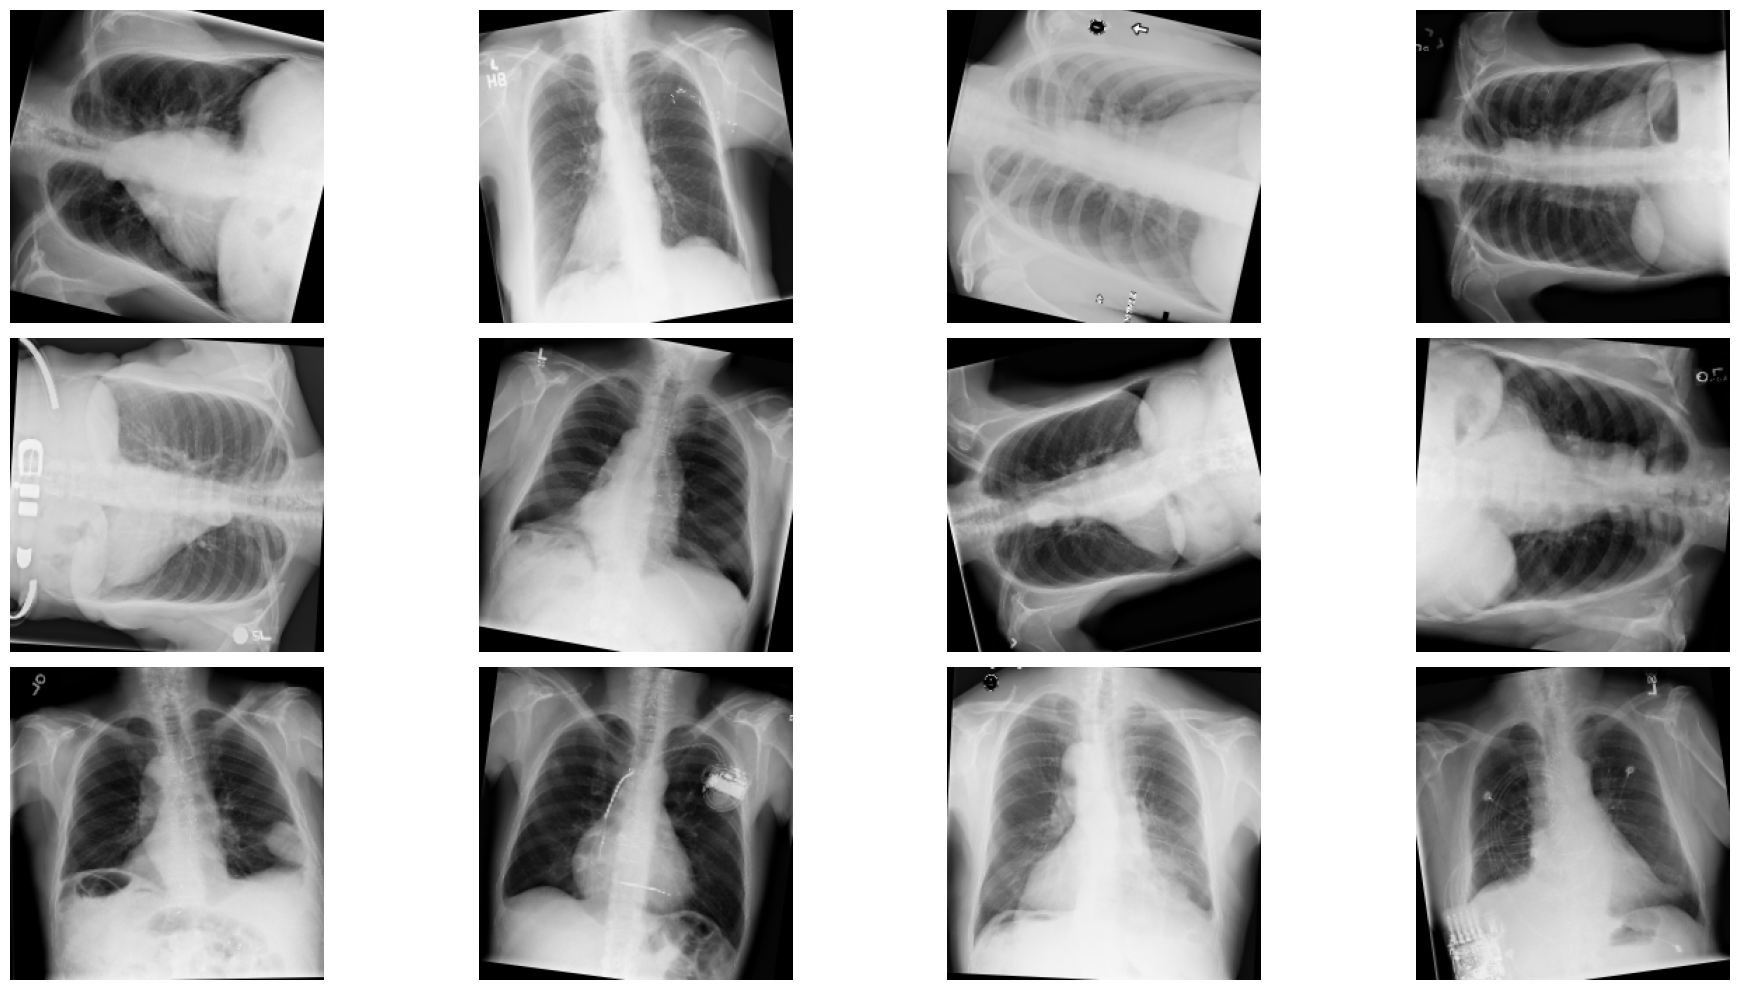

In [16]:
data, _ = dtrain.take(2)
images = data[0].numpy()
fig, axes = plt.subplots(3, 4, figsize=(20,10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [17]:
# Рассчитаем веса для классов, ибо у нас присутствует дисбаланс
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_labels),
                                                  y=train_labels)

class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.6563017031630171, 1: 2.0994707347447075}

In [18]:
def build_model():
    base_model = DenseNet121(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)

    attention = layers.Dense(1024, activation='relu')(x)
    attention = layers.Dense(1024, activation='sigmoid')(attention)
    x = layers.Multiply()([x, attention])

    x = layers.Dense(1, activation='sigmoid')(x)

    return Model(inputs=base_model.input, outputs=x)

model = build_model()
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.0)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=loss, metrics=[tf.keras.metrics.AUC()])

In [19]:
rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, verbose = 1, min_delta = 1e-4, min_lr = 1e-7, mode = 'min', cooldown=1)
ckp = ModelCheckpoint(name, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')
es = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 11, mode = 'min', restore_best_weights = True, verbose = 1)

callbacks_list = [rlr, ckp, es]

In [20]:
history = model.fit(dtrain,
                    validation_data=dvalid,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    steps_per_epoch=train_paths.shape[0]//BATCH_SIZE,
                    verbose=1,
                    class_weight=class_weights)

Epoch 1/100


2024-08-27 20:36:49.141277: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
I0000 00:00:1724765809.292315   15058 service.cc:145] XLA service 0x7fb5e80051f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724765809.292378   15058 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-08-27 20:36:51.284579: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-27 20:36:56.324567: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1724765820.250274   15125 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_30841', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1724765820.770591   15126 

421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - auc: 0.6178 - loss: 0.6678

2024-08-27 20:39:35.502264: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
I0000 00:00:1724765989.997129   15267 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3304', 240 bytes spill stores, 240 bytes spill loads

I0000 00:00:1724765990.309190   15277 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3311', 260 bytes spill stores, 260 bytes spill loads




Epoch 1: val_loss improved from inf to 0.67212, saving model to Сomparison_of_data_model.keras
421/421 ━━━━━━━━━━━━━━━━━━━━ 231s 238ms/step - auc: 0.6178 - loss: 0.6678 - val_auc: 0.5243 - val_loss: 0.6721 - learning_rate: 1.0000e-04
Epoch 2/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - auc: 0.6493 - loss: 0.6407

2024-08-27 20:41:14.694479: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 2: val_loss improved from 0.67212 to 0.63588, saving model to Сomparison_of_data_model.keras
421/421 ━━━━━━━━━━━━━━━━━━━━ 80s 190ms/step - auc: 0.6494 - loss: 0.6407 - val_auc: 0.6017 - val_loss: 0.6359 - learning_rate: 1.0000e-04
Epoch 3/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - auc: 0.6699 - loss: 0.6279

2024-08-27 20:42:33.602496: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 3: val_loss improved from 0.63588 to 0.58381, saving model to Сomparison_of_data_model.keras
421/421 ━━━━━━━━━━━━━━━━━━━━ 80s 189ms/step - auc: 0.6700 - loss: 0.6279 - val_auc: 0.6700 - val_loss: 0.5838 - learning_rate: 1.0000e-04
Epoch 4/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - auc: 0.7019 - loss: 0.6104

2024-08-27 20:43:52.272937: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 4: val_loss did not improve from 0.58381
421/421 ━━━━━━━━━━━━━━━━━━━━ 79s 188ms/step - auc: 0.7020 - loss: 0.6104 - val_auc: 0.6822 - val_loss: 0.6037 - learning_rate: 1.0000e-04
Epoch 5/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - auc: 0.7135 - loss: 0.6019

2024-08-27 20:45:09.816662: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 5: val_loss did not improve from 0.58381
421/421 ━━━━━━━━━━━━━━━━━━━━ 77s 184ms/step - auc: 0.7135 - loss: 0.6019 - val_auc: 0.6585 - val_loss: 0.6429 - learning_rate: 1.0000e-04
Epoch 6/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - auc: 0.7201 - loss: 0.5953

2024-08-27 20:46:27.103562: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 6: val_loss improved from 0.58381 to 0.57932, saving model to Сomparison_of_data_model.keras
421/421 ━━━━━━━━━━━━━━━━━━━━ 81s 193ms/step - auc: 0.7201 - loss: 0.5953 - val_auc: 0.6828 - val_loss: 0.5793 - learning_rate: 1.0000e-04
Epoch 7/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - auc: 0.7280 - loss: 0.5901

2024-08-27 20:47:45.153606: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 7: val_loss did not improve from 0.57932
421/421 ━━━━━━━━━━━━━━━━━━━━ 74s 176ms/step - auc: 0.7280 - loss: 0.5901 - val_auc: 0.5976 - val_loss: 0.6412 - learning_rate: 1.0000e-04
Epoch 8/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - auc: 0.7407 - loss: 0.5822

2024-08-27 20:49:02.456675: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 8: val_loss did not improve from 0.57932
421/421 ━━━━━━━━━━━━━━━━━━━━ 79s 189ms/step - auc: 0.7407 - loss: 0.5822 - val_auc: 0.7038 - val_loss: 0.6055 - learning_rate: 1.0000e-04
Epoch 9/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - auc: 0.7369 - loss: 0.5823

2024-08-27 20:50:21.205427: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 9: val_loss did not improve from 0.57932
421/421 ━━━━━━━━━━━━━━━━━━━━ 77s 182ms/step - auc: 0.7369 - loss: 0.5823 - val_auc: 0.5757 - val_loss: 0.6384 - learning_rate: 1.0000e-04
Epoch 10/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - auc: 0.7575 - loss: 0.5671

2024-08-27 20:51:39.904228: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 10: val_loss improved from 0.57932 to 0.53592, saving model to Сomparison_of_data_model.keras
421/421 ━━━━━━━━━━━━━━━━━━━━ 83s 197ms/step - auc: 0.7576 - loss: 0.5671 - val_auc: 0.7510 - val_loss: 0.5359 - learning_rate: 1.0000e-04
Epoch 11/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - auc: 0.7564 - loss: 0.5673

2024-08-27 20:52:58.115715: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 11: val_loss did not improve from 0.53592
421/421 ━━━━━━━━━━━━━━━━━━━━ 77s 182ms/step - auc: 0.7565 - loss: 0.5673 - val_auc: 0.7223 - val_loss: 0.5597 - learning_rate: 1.0000e-04
Epoch 12/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - auc: 0.7652 - loss: 0.5595

2024-08-27 20:54:17.166040: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 12: val_loss improved from 0.53592 to 0.53177, saving model to Сomparison_of_data_model.keras
421/421 ━━━━━━━━━━━━━━━━━━━━ 78s 186ms/step - auc: 0.7652 - loss: 0.5595 - val_auc: 0.7636 - val_loss: 0.5318 - learning_rate: 1.0000e-04
Epoch 13/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - auc: 0.7783 - loss: 0.5453

2024-08-27 20:55:36.836129: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 13: val_loss improved from 0.53177 to 0.51772, saving model to Сomparison_of_data_model.keras
421/421 ━━━━━━━━━━━━━━━━━━━━ 82s 194ms/step - auc: 0.7783 - loss: 0.5453 - val_auc: 0.7871 - val_loss: 0.5177 - learning_rate: 1.0000e-04
Epoch 14/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - auc: 0.7868 - loss: 0.5415

2024-08-27 20:56:57.083184: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 14: val_loss improved from 0.51772 to 0.50800, saving model to Сomparison_of_data_model.keras
421/421 ━━━━━━━━━━━━━━━━━━━━ 80s 190ms/step - auc: 0.7868 - loss: 0.5415 - val_auc: 0.8065 - val_loss: 0.5080 - learning_rate: 1.0000e-04
Epoch 15/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - auc: 0.7893 - loss: 0.5363

2024-08-27 20:58:16.290959: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 15: val_loss did not improve from 0.50800
421/421 ━━━━━━━━━━━━━━━━━━━━ 78s 185ms/step - auc: 0.7893 - loss: 0.5362 - val_auc: 0.8128 - val_loss: 0.5204 - learning_rate: 1.0000e-04
Epoch 16/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - auc: 0.8035 - loss: 0.5243

2024-08-27 20:59:36.754360: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 16: val_loss improved from 0.50800 to 0.46743, saving model to Сomparison_of_data_model.keras
421/421 ━━━━━━━━━━━━━━━━━━━━ 79s 189ms/step - auc: 0.8036 - loss: 0.5243 - val_auc: 0.8352 - val_loss: 0.4674 - learning_rate: 1.0000e-04
Epoch 17/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - auc: 0.8050 - loss: 0.5213

2024-08-27 21:00:56.682611: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 17: val_loss did not improve from 0.46743
421/421 ━━━━━━━━━━━━━━━━━━━━ 78s 186ms/step - auc: 0.8050 - loss: 0.5213 - val_auc: 0.8177 - val_loss: 0.4889 - learning_rate: 1.0000e-04
Epoch 18/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - auc: 0.8133 - loss: 0.5123

2024-08-27 21:02:15.364022: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 18: val_loss improved from 0.46743 to 0.46381, saving model to Сomparison_of_data_model.keras
421/421 ━━━━━━━━━━━━━━━━━━━━ 81s 193ms/step - auc: 0.8134 - loss: 0.5123 - val_auc: 0.8359 - val_loss: 0.4638 - learning_rate: 1.0000e-04
Epoch 19/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - auc: 0.8262 - loss: 0.4972

2024-08-27 21:03:34.798962: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 19: val_loss did not improve from 0.46381
421/421 ━━━━━━━━━━━━━━━━━━━━ 79s 187ms/step - auc: 0.8263 - loss: 0.4972 - val_auc: 0.8281 - val_loss: 0.4805 - learning_rate: 1.0000e-04
Epoch 20/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - auc: 0.8359 - loss: 0.4877

2024-08-27 21:04:53.016603: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 20: val_loss did not improve from 0.46381
421/421 ━━━━━━━━━━━━━━━━━━━━ 78s 186ms/step - auc: 0.8359 - loss: 0.4878 - val_auc: 0.8179 - val_loss: 0.5649 - learning_rate: 1.0000e-04
Epoch 21/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - auc: 0.8446 - loss: 0.4768

2024-08-27 21:06:10.362699: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 21: val_loss did not improve from 0.46381
421/421 ━━━━━━━━━━━━━━━━━━━━ 77s 184ms/step - auc: 0.8446 - loss: 0.4768 - val_auc: 0.7923 - val_loss: 0.5118 - learning_rate: 1.0000e-04
Epoch 22/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - auc: 0.8464 - loss: 0.4752

2024-08-27 21:07:27.343976: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 22: val_loss did not improve from 0.46381
421/421 ━━━━━━━━━━━━━━━━━━━━ 75s 177ms/step - auc: 0.8464 - loss: 0.4752 - val_auc: 0.8219 - val_loss: 0.4774 - learning_rate: 1.0000e-04
Epoch 23/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - auc: 0.8628 - loss: 0.4504

2024-08-27 21:08:46.802390: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 23: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 23: val_loss did not improve from 0.46381
421/421 ━━━━━━━━━━━━━━━━━━━━ 79s 188ms/step - auc: 0.8628 - loss: 0.4504 - val_auc: 0.7699 - val_loss: 0.5510 - learning_rate: 1.0000e-04
Epoch 24/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - auc: 0.8740 - loss: 0.4361

2024-08-27 21:10:05.148318: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 24: val_loss did not improve from 0.46381
421/421 ━━━━━━━━━━━━━━━━━━━━ 78s 186ms/step - auc: 0.8740 - loss: 0.4361 - val_auc: 0.7709 - val_loss: 0.5509 - learning_rate: 1.0000e-05
Epoch 25/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - auc: 0.8915 - loss: 0.4086

2024-08-27 21:11:23.990217: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 25: val_loss did not improve from 0.46381
421/421 ━━━━━━━━━━━━━━━━━━━━ 81s 193ms/step - auc: 0.8915 - loss: 0.4086 - val_auc: 0.7751 - val_loss: 0.5820 - learning_rate: 1.0000e-05
Epoch 26/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - auc: 0.9039 - loss: 0.3865

2024-08-27 21:12:41.604360: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 26: val_loss did not improve from 0.46381
421/421 ━━━━━━━━━━━━━━━━━━━━ 77s 183ms/step - auc: 0.9039 - loss: 0.3865 - val_auc: 0.7891 - val_loss: 0.6186 - learning_rate: 1.0000e-05
Epoch 27/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - auc: 0.9059 - loss: 0.3804

2024-08-27 21:14:00.768217: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 27: val_loss did not improve from 0.46381
421/421 ━━━━━━━━━━━━━━━━━━━━ 79s 189ms/step - auc: 0.9060 - loss: 0.3804 - val_auc: 0.7960 - val_loss: 0.6636 - learning_rate: 1.0000e-05
Epoch 28/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - auc: 0.9181 - loss: 0.3576

2024-08-27 21:15:20.539282: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 28: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 28: val_loss did not improve from 0.46381
421/421 ━━━━━━━━━━━━━━━━━━━━ 80s 189ms/step - auc: 0.9181 - loss: 0.3576 - val_auc: 0.7944 - val_loss: 0.7133 - learning_rate: 1.0000e-05
Epoch 29/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - auc: 0.9172 - loss: 0.3595

2024-08-27 21:16:39.408419: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Epoch 29: val_loss did not improve from 0.46381
421/421 ━━━━━━━━━━━━━━━━━━━━ 77s 182ms/step - auc: 0.9172 - loss: 0.3595 - val_auc: 0.7586 - val_loss: 0.6119 - learning_rate: 1.0000e-06
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 18.


2024-08-27 21:16:45.967747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node cond/pivot_t/_4/_19}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2024-08-27 21:16:45.968088: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1763172952913074232
2024-08-27 21:16:45.968132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node cond/pivot_t/_4/_19}}]]
	 [[cond/then/_0/cond/random_rotation_1_1/stateful_uniform/RngReadAndSkip/_24]] [type.googleapis.com/tensorflow.DerivedStatus='']
2024-08-27 21:16:45.968178: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1357009311240530699
2024-08-27 21:16:45.968213: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2128359

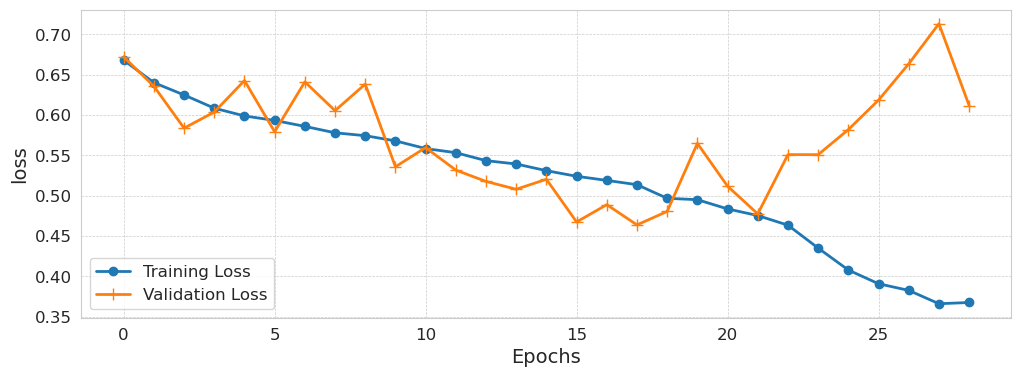

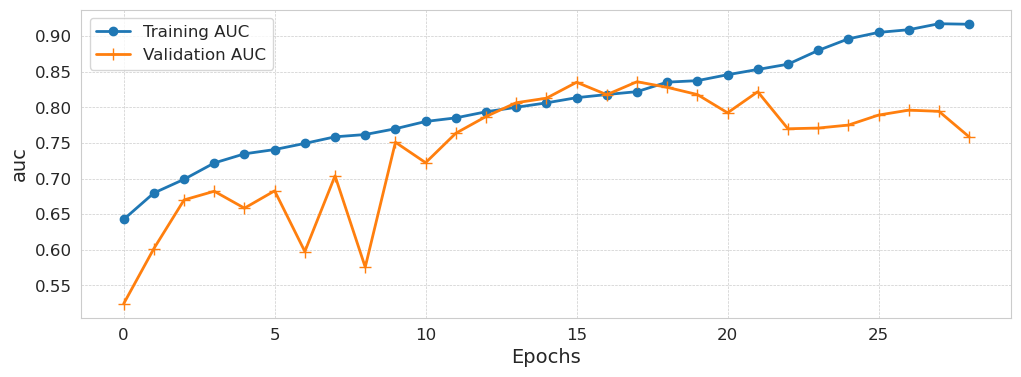

In [21]:
plot_loss_metrics(history, "loss", "auc", "Loss", "AUC")

36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 290ms/step
AUC для Nodule/Mass
0.8360129775315844


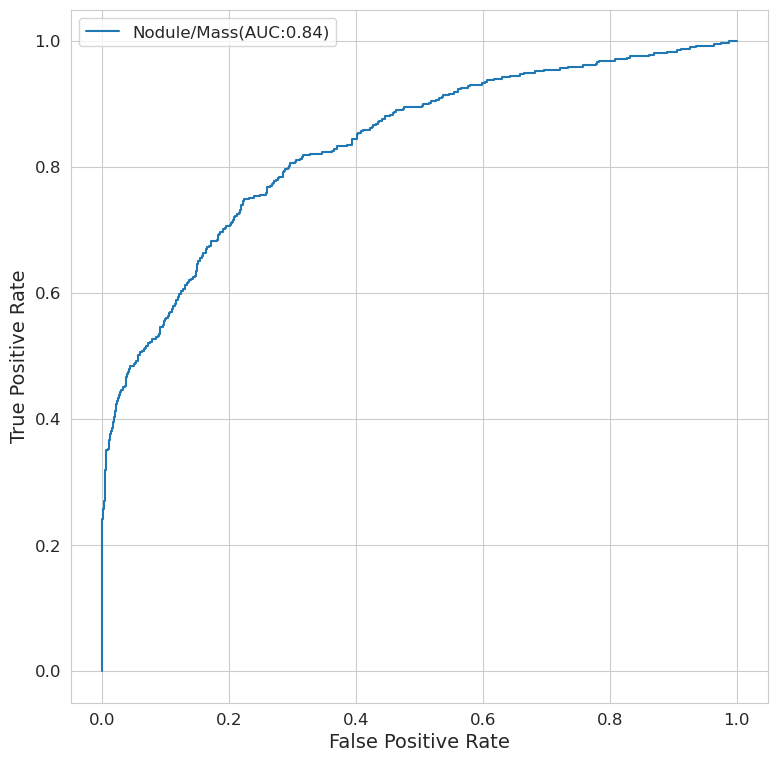

In [22]:
plot_roc_auc(name, dvalid, valid_labels)

# Сравнение моделей

In [23]:
tf.keras.backend.clear_session()

model1 = tf.keras.models.load_model("Correctly_data_model.keras")
pred1 = model1.predict(dvalid, verbose=1)

model2 = tf.keras.models.load_model("Сomparison_of_data_model.keras")
pred2 = model2.predict(dvalid, verbose=1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 263ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 263ms/step


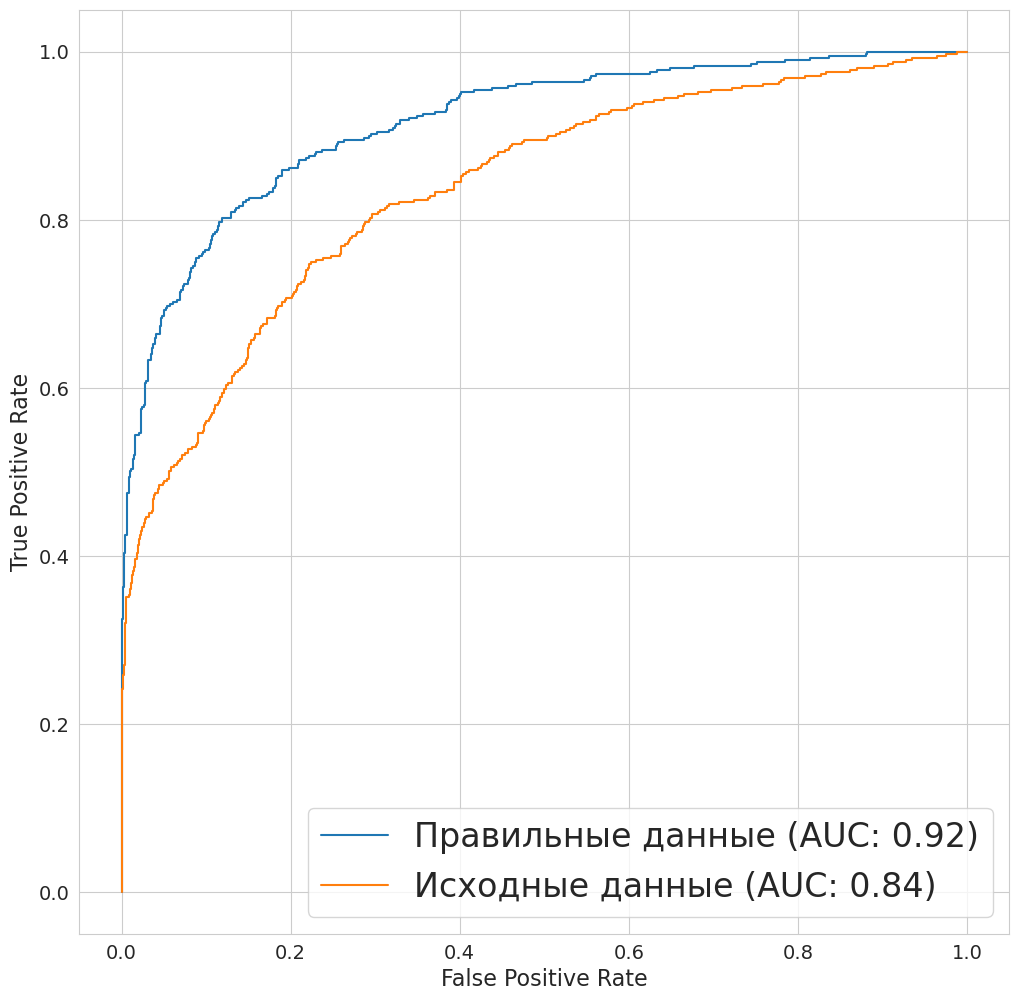

In [24]:
fig, c_ax = plt.subplots(1, 1, figsize=(12, 12))

fpr1, tpr1, thresholds1 = roc_curve(valid_labels, pred1)
c_ax.plot(fpr1, tpr1, label=f'Правильные данные (AUC: {roc_auc_score(valid_labels, pred1):.2f})')

fpr2, tpr2, thresholds2 = roc_curve(valid_labels, pred2)
c_ax.plot(fpr2, tpr2, label=f'Исходные данные (AUC: {roc_auc_score(valid_labels, pred2):.2f})')

c_ax.legend(fontsize=24)
c_ax.set_xlabel('False Positive Rate', fontsize=16)
c_ax.set_ylabel('True Positive Rate', fontsize=16)
c_ax.tick_params(axis='both', which='major', labelsize=14)
fig.savefig("Сравнение_моделей_ROC_AUC.png")
plt.show()

# Выводы

Из полученных результатов явно видно, что модель, обученная на верно размеченных данных, показывает значительно более высокие результаты по сравнению с моделью, обученной на исходных данных. В частности, на правильно размеченных данных значение ROC AUC составляет 0.92, в то время как на исходных данных оно достигает лишь 0.84. Это свидетельствует о том, что точность и качество разметки данных играют решающую роль в обучении и эффективности моделей машинного обучения.